### Train
- unfreeze vgg after 2000 iterations
- decrease lr by half if it does not give a new lowest loss in 2000 iterations
- In this notebook, the model is trained for 28200 iterations from scratch

In [1]:
import torch
import torchvision
import torch.nn as nn
from PIL import Image
from PIL import ImageOps
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np
import json
import copy
from torchvision.models import vgg19
import cv2
import torch.nn.functional as Func
import warnings
warnings.filterwarnings("ignore")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
def get_heat_ps(size=15, sigma2=25):
    m = np.empty((size,size))
    c = size//2
    for i in range(size):
        for j in range(size):
            m[i,j] = (i-c)**2 + (j-c)**2
    m = np.exp(-m/sigma2)
    return m

## Constants

In [4]:
idx_to_keypoint_type = {0: 'nose', 1: 'left_eye', 2: 'right_eye', 3: 'left_ear', 4: 'right_ear', 5: 'left_shoulder', 6: 'right_shoulder', 7: 'left_elbow', 8: 'right_elbow', 9: 'left_wrist', 10: 'right_wrist', 11: 'left_hip', 12: 'right_hip', 13: 'left_knee', 14: 'right_knee', 15: 'left_ankle', 16: 'right_ankle'}

keypoint_type_to_idx = {'nose': 0, 'left_eye': 1, 'right_eye': 2, 'left_ear': 3, 'right_ear': 4, 'left_shoulder': 5, 'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8, 'left_wrist': 9, 'right_wrist': 10, 'left_hip': 11, 'right_hip': 12, 'left_knee': 13, 'right_knee': 14, 'left_ankle': 15, 'right_ankle': 16}

part_pairs = [['left_ankle', 'left_knee'], ['left_knee', 'left_hip'], ['right_ankle', 'right_knee'], ['right_knee', 'right_hip'], ['left_hip', 'right_hip'], ['left_shoulder', 'left_hip'], ['right_shoulder', 'right_hip'], ['left_shoulder', 'right_shoulder'], ['left_shoulder', 'left_elbow'], ['right_shoulder', 'right_elbow'], ['left_elbow', 'left_wrist'], ['right_elbow', 'right_wrist'], ['left_eye', 'right_eye'], ['nose', 'left_eye'], ['nose', 'right_eye'], ['left_eye', 'left_ear'], ['right_eye', 'right_ear'], ['left_ear', 'left_shoulder'], ['right_ear', 'right_shoulder'], ['left_shoulder', 'left_wrist'], ['right_shoulder', 'right_wrist'], ['left_hip', 'left_ankle'], ['right_hip', 'right_ankle']]

keypoint_labels = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']

KEYPOINT_ORDER = np.arange(0,17)

SMALLER_HEATMAP_GROUP = np.arange(0,5)#['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear']

SKELETON = np.array([[15, 13], [13, 11], [16, 14], [14, 12], [11, 12], [5, 11], [6, 12], [5, 6], [5, 7], [6, 8], [7, 9], [8, 10], [1, 2], [0, 1], [0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5,9], [6,10], [11,15], [12,16]])
INFERENCE_SKELETON = np.array([[15, 13], [13, 11], [16, 14], [14, 12], [11, 12], [5, 11], [6, 12], [5, 6], [5, 7], [6, 8], [7, 9], [8, 10], [1, 2], [0, 1], [0, 2], [1, 3], [2, 4], [3, 5], [4, 6]])

GAUSSIAN_15X15 = np.load('util_data/gaussian_15X15_sigma_7.npy')
# GAUSSIAN_15X15 = get_heat_ps(size=15, sigma2=49)
GAUSSIAN_9X9 = np.load('util_data/gaussian_9X9_sigma_3.npy')
# GAUSSIAN_9X9 = get_heat_ps(size=9, sigma2=9)
GAUSSIAN_5X5 = np.load('util_data/gaussian_5X5_sigma_3.npy')
# GAUSSIAN_5X5 = get_heat_ps(size=5, sigma2=9)

heatmap_ps_map = {'ps_vals':GAUSSIAN_15X15,'ps':15, 'ps_small_vals':GAUSSIAN_9X9, 'ps_small':9}

## Transform

In [5]:
class Denorm(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        return tensor.mul(self.std).add(self.mean)
    
class RandomCrop(object):
    def __init__(self, size=368, p=1):
        self.sz = size
        self.p = p
        
    def __call__(self, sample):
        image = sample['image']
        keypoints = sample['keypoints']
        H, W = image.height, image.width
        
        if (W>self.sz and H>self.sz and np.random.random()>(1-self.p)):
            x = np.random.randint(W - self.sz)
            y = np.random.randint(H - self.sz)
            croped_img = image.crop(box=(x,y, x+self.sz, y+self.sz))
            
            keypoints[keypoints[:,:,0]<x] = np.array([0,0,0])
            keypoints[keypoints[:,:,1]<y] = np.array([0,0,0])
            keypoints[keypoints[:,:,0]>x+self.sz] = np.array([0,0,0])
            keypoints[keypoints[:,:,1]>y+self.sz] = np.array([0,0,0])
            keypoints[:,:,:2][keypoints[:,:,2]>0] = keypoints[:,:,:2][keypoints[:,:,2]>0] - np.array([[x, y]])
            
            return { 'image' : croped_img, 'keypoints':keypoints }
        else: return sample

class ResizeImgAndKeypoints(object):
    def __init__(self, size=368):
        self.size = size
        self.paf_sz = int(size*46/368)
        self.Resize = transforms.Resize((self.paf_sz, self.paf_sz))
    
    def __call__(self, sample):
        image = sample['image']
        keypoints = sample['keypoints'].copy().astype(float) #2x17x3
        IM_H, IM_W = image.height, image.width
        if(IM_H > IM_W):
            w = int(self.size*IM_W/IM_H)
            h = self.size
            pad_val = int((self.size-w)/2)
            pad = (self.size-w-pad_val,0,pad_val ,0)
            keypoints[:,:,0] = keypoints[:,:,0]*(w/IM_W)
            keypoints[:,:,0][keypoints[:,:,2]>0] += self.size-w-pad_val
            keypoints[:,:,1] = keypoints[:,:,1]*(self.size/IM_H)
        
        else:
            h = int(self.size*IM_H/IM_W)
            w = self.size
            pad_val = int((self.size-h)/2)
            pad = (0,self.size-h-pad_val,0,pad_val)
            keypoints[:,:,0] = keypoints[:,:,0]*(self.size/IM_W)
            keypoints[:,:,1] = keypoints[:,:,1]*(h/IM_H)
            keypoints[:,:,1][keypoints[:,:,2]>0] += self.size-h-pad_val
        
        resized_img = ImageOps.expand(image.resize((w,h),resample=Image.BILINEAR), pad)
        return { 'image' : resized_img , 'image_stg_input': self.Resize(resized_img),'keypoints' : keypoints }

class FlipHR(object):
    def __init__(self, p=0.25):
        self.p = p
    
    def __call__(self, sample):
        image = sample['image']
        keypoints = sample['keypoints']
        
        if np.random.random() > (1-self.p):
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            w, h = image.size
            keypoints[:, :, 0][keypoints[:, :, 2]>0] = w - keypoints[:, :, 0][keypoints[:, :, 2]>0]
            copy = keypoints.copy()
            keypoints[:,1,:], keypoints[:,2,:] = copy[:,2,:], copy[:,1,:]
            keypoints[:,3,:], keypoints[:,4,:] = copy[:,4,:], copy[:,3,:]
            keypoints[:,5,:], keypoints[:,6,:] = copy[:,6,:], copy[:,5,:]
            keypoints[:,7,:], keypoints[:,8,:] = copy[:,8,:], copy[:,7,:]
            keypoints[:,9,:], keypoints[:,10,:] = copy[:,10,:], copy[:,9,:]
            keypoints[:,11,:], keypoints[:,12,:] = copy[:,12,:], copy[:,11,:]
            keypoints[:,13,:], keypoints[:,14,:] = copy[:,14,:], copy[:,13,:]
            keypoints[:,15,:], keypoints[:,16,:] = copy[:,16,:], copy[:,15,:]
        
            return { 'image' : image, 'image_stg_input': ImageOps.mirror(sample['image_stg_input']) ,'keypoints' : keypoints }
        else: return sample

class FlipUD(object):
    def __init__(self, p=0.2):
        self.p = p
    
    def __call__(self, sample):
        image = sample['image']
        keypoints = sample['keypoints']
        
        if np.random.random() > (1-self.p):
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
            w, h = image.size
            keypoints[:, :, 1][keypoints[:, :, 2]>0] = h - keypoints[:, :, 1][keypoints[:, :, 2]>0]
            copy = keypoints.copy()
            keypoints[:,1,:], keypoints[:,2,:] = copy[:,2,:], copy[:,1,:]
            keypoints[:,3,:], keypoints[:,4,:] = copy[:,4,:], copy[:,3,:]
            keypoints[:,5,:], keypoints[:,6,:] = copy[:,6,:], copy[:,5,:]
            keypoints[:,7,:], keypoints[:,8,:] = copy[:,8,:], copy[:,7,:]
            keypoints[:,9,:], keypoints[:,10,:] = copy[:,10,:], copy[:,9,:]
            keypoints[:,11,:], keypoints[:,12,:] = copy[:,12,:], copy[:,11,:]
            keypoints[:,13,:], keypoints[:,14,:] = copy[:,14,:], copy[:,13,:]
            keypoints[:,15,:], keypoints[:,16,:] = copy[:,16,:], copy[:,15,:]
        
            return { 'image' : image, 'image_stg_input': ImageOps.flip(sample['image_stg_input']) ,'keypoints' : keypoints }
        else: return sample
        
class ColorJitter(object):
    def __init__(self, brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1):
        self.tfm = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
    
    def __call__(self, sample):
        image = self.tfm(sample['image'])
        return { 'image' : image, 'image_stg_input': sample['image_stg_input'], 'keypoints': sample['keypoints'] }

class RandomGrayscale(object):
    def __init__(self, p=0.33):
        self.tfm = transforms.RandomGrayscale(p=p)
        self.gs = transforms.Grayscale(num_output_channels=3)
    
    def __call__(self, sample):
        image = self.tfm(sample['image'])
        if(len(image.getbands())<3):
            image = self.gs(image)
            sample['image_stg_input'] = self.gs(sample['image_stg_input'])
        return { 'image' : image, 'image_stg_input' : sample['image_stg_input'], 'keypoints': sample['keypoints'] }

class RandomRotateImgAndKeypoints(object):
    def __init__(self, deg=30, p=0.9):
        self.deg = deg
        self.p = p
    
    def __rotate__(self, origin, keypoints, deg, sz):
        ox, oy = origin
        theta = np.math.radians(-deg) #-deg since we measure y,x from top left and not w/2,h/2
        X = keypoints[:,:,0][keypoints[:,:,2]>0]
        Y = keypoints[:,:,1][keypoints[:,:,2]>0]
        
        keypoints[:,:,0][keypoints[:,:,2]>0] = ox + (np.math.cos(theta)*(X - ox) - np.math.sin(theta)*(Y - oy)) 
        keypoints[:,:,1][keypoints[:,:,2]>0] = oy + (np.math.sin(theta)*(X - ox) + np.math.cos(theta)*(Y - oy)) 
        
        inds = np.logical_or(np.any((keypoints[:,:,:2]<0), axis=2), np.any((keypoints[:,:,:2]>sz), axis=2))
        keypoints[inds,:] = np.array([0,0,0])
        return keypoints
    
    def __call__(self, sample):
        if(np.random.random()>(1-self.p)):
            image = sample['image']
            keypoints = sample['keypoints'].copy()
            rand_deg = np.random.randint(-1*self.deg, self.deg+1)
            image = image.rotate(rand_deg)
            w, h = image.size
            res = self.__rotate__((w/2, h/2), keypoints, rand_deg, h)
            return { 'image' : image, 'image_stg_input' : sample['image_stg_input'].rotate(rand_deg) ,'keypoints' : res }
        else:
            return sample

class ToTensor(object):
    def __init__(self):
        self.ToTensor = transforms.ToTensor()
    
    def __call__(self, sample):
        return { 'image' : self.ToTensor(sample['image']),
                 'image_stg_input' : self.ToTensor(sample['image_stg_input']),
                 'pafs' : torch.tensor(sample['pafs'], dtype=torch.float),
                 'PAF_BINARY_IND' : torch.tensor(sample['PAF_BINARY_IND'], dtype=torch.uint8),
                 'heatmaps' : torch.tensor(sample['heatmaps'], dtype=torch.float),
                 'HM_BINARY_IND' : torch.tensor(sample['HM_BINARY_IND'], dtype=torch.uint8),
                }

class NormalizeImg(object):
    def __init__(self, mean, std):
        self.normalize = transforms.Normalize(mean, std)
    
    def __call__(self, sample):
        sample['image'] = self.normalize(sample['image'])
        return sample

class UnNormalizeImgBatch(object):
    def __init__(self, mean, std):
        self.mean = mean.reshape((1,3,1,1))
        self.std = std.reshape((1,3,1,1))
    
    def __call__(self, batch):
        return (batch*self.std) + self.mean

class Resize(object):
    def __init__(self, size=368):
        self.size = size
    
    def __call__(self, im):
        if(im.height > im.width):
            w = int(self.size*im.width/im.height)
            h = self.size
            pad_val = int((self.size-w)/2)
            pad = (self.size-w-pad_val,0,pad_val,0)
        else:
            h = int(self.size*im.height/im.width)
            w = self.size
            pad_val = int((self.size-h)/2)
            pad = (0,self.size-h-pad_val,0,pad_val)
        return ImageOps.expand(im.resize((w,h),resample=Image.BILINEAR), pad)

## Dataset

In [6]:
def CALCULATE_PAF_MASK(fliped_img, joint_pair, keypoints, limb_width):
    j1_idx, j2_idx = joint_pair[0], joint_pair[1]
    mask = np.zeros((46, 46))               #in x,y order
    col, row = np.ogrid[:46, :46]
    
    paf_p_x = np.zeros((len(keypoints), 46, 46))
    paf_p_y = np.zeros((len(keypoints), 46, 46))
    NON_ZERO_VEC_COUNT = np.zeros((2, 46, 46))
    PAF_IND = False
    final_paf_map = np.zeros((2, 46, 46))
    
    for i, item in enumerate(keypoints):
        j1, j2 =  item[j1_idx][:2], item[j2_idx][:2]
        keypoints_detected = item[j1_idx][2] and item[j2_idx][2]
        PAF_IND = PAF_IND or keypoints_detected>0
        if(keypoints_detected):
            limb_length = np.linalg.norm(j2 - j1)
            if(limb_length > 1e-8):
                v = (j2 - j1) / limb_length
                v_perp = np.array([v[1], -v[0]])
                center_point = (j1 + j2)/2
                
                cond1 = np.abs(np.dot(v, np.array([col, row]) - center_point))<=limb_length/2
                cond2 = np.abs(np.dot(v_perp, np.array([col, row]) - j1))<=limb_width
                mask = np.logical_and(cond1, cond2)
                
                paf_p_x[i], paf_p_y[i] = mask*v[0], mask*v[1]
                if(v[0]):
                    NON_ZERO_VEC_COUNT[0][mask] +=1
                if(v[1]):
                    NON_ZERO_VEC_COUNT[1][mask] +=1

    NON_ZERO_VEC_COUNT[NON_ZERO_VEC_COUNT==0] = 1
    final_paf_map[0], final_paf_map[1] = (paf_p_x.sum(axis=0)/NON_ZERO_VEC_COUNT[0]), (paf_p_y.sum(axis=0)/NON_ZERO_VEC_COUNT[1])
    return final_paf_map, PAF_IND



def GET_PAF_MAP(img_stg_input, keypoints, limb_width, part_pairs=SKELETON):
    img_stg_input = np.array(img_stg_input)
    downsample_ratio = 0.125

    pafs = np.zeros((len(part_pairs)*2, 46, 46))
    PAF_BINARY_IND = np.zeros(len(part_pairs)*2)
    fliped_img = img_stg_input.transpose((1,0,2))
    kps_copy = keypoints.copy()
    kps_copy[:,:,:2][kps_copy[:,:,2]>0] = kps_copy[:,:,:2][kps_copy[:,:,2]>0]*downsample_ratio
    
    for i, joint_pair in enumerate(part_pairs):
        mask, PAF_IS_LABELED = CALCULATE_PAF_MASK(fliped_img, joint_pair, kps_copy, downsample_ratio*limb_width)

        PAF_BINARY_IND[2*i], PAF_BINARY_IND[(2*i)+1]  = int(PAF_IS_LABELED), int(PAF_IS_LABELED)
        mask = mask.transpose((0,2,1))
        pafs[2*i], pafs[(2*i) +1] = mask[0], mask[1]   #x component, y component of v
    return pafs, PAF_BINARY_IND

In [7]:
def CALCULATE_HEATMAP(fliped_img, kp_id, keypoints, pad, hm_sz):
    H,W = fliped_img.shape[:2]
    ps = 15
    g_vals = heatmap_ps_map['ps_vals'].copy()
    if(kp_id in SMALLER_HEATMAP_GROUP):
        ps = int(heatmap_ps_map['ps_small'])
        g_vals = heatmap_ps_map['ps_small_vals'].copy()
    
    ps_hf = ps//2
    points = keypoints[:,kp_id, :2][keypoints[:,kp_id,2]>0]
    points = np.rint(points).astype(int)
    KEYPOINT_EXISTS = (len(points)>0)
    mask = np.zeros((H, W))
    
    for (x,y) in points:
        mask[x-ps_hf : x+ps_hf+1, y-ps_hf : y+ps_hf+1] = g_vals
    
    mask = mask[pad:-pad, pad:-pad]
    return mask, KEYPOINT_EXISTS



def GET_HEAT_MAP(img, keypoints, sigma):
    img = np.array(img)
    h,w = img.shape[:2]
    pad = 8
    kp_ids = np.arange(0,17)
    img = np.pad(img, pad_width=[(pad,pad),(pad,pad),(0,0)], mode='constant', constant_values=0)
    heatmaps = np.zeros((len(kp_ids)+1, h, w))
    HM_BINARY_IND = np.zeros(len(kp_ids)+1)
    fliped_img = img.transpose((1,0,2)) # why flip ?
    kps_copy = keypoints.copy()
    
    kps_copy[:,:,:2][kps_copy[:,:,2]>0] = kps_copy[:,:,:2][kps_copy[:,:,2]>0]+pad
    
    for i, kp_id in enumerate(kp_ids):
        mask, HM_IS_LABELED = CALCULATE_HEATMAP(fliped_img, kp_id, kps_copy, pad, h)
        HM_BINARY_IND[i] = int(HM_IS_LABELED)
        mask = mask.transpose()
        heatmaps[i] = mask
        
    heatmaps[len(kp_ids)] = np.ones((h,w)) - np.sum(heatmaps, axis=0)
    
    HM_BINARY_IND[len(kp_ids)] = 1
    
    return heatmaps, HM_BINARY_IND

In [8]:
class COCO_Person_Dataset(torch.utils.data.Dataset):
    def __init__(self, file, tfms, tensor_tfms, devide=None):
        super(COCO_Person_Dataset, self).__init__()
        
        self.devide = devide
        json_file = json.load(open(file))
        self.images = []
        self.keypoints = []
        for f in json_file:
            self.images.append(f[0]) # image path
            key_list = f[1]
            keypoints = []
            for k in key_list:
                keypoints.append(list(zip(k[::3],k[1::3], k[2::3])))
            self.keypoints.append(np.array(keypoints))
#         self.keypoints = np.array(self.keypoints)
            
        self.len = len(self.images)        
        self.tfms = tfms
        self.tensor_tfms = tensor_tfms
        self.get_heatmap_masks = GET_HEAT_MAP     
        self.get_paf_masks = GET_PAF_MAP
        
        self.limb_width = 5        
        self.sigma = 7
            
  
    def __getitem__(self, index):
        image = Image.open(self.images[index].split('/coco2014/')[1]).copy()
        if(image.mode!='RGB'):
#             print('gray value image: '+self.images[index])
            image = image.convert('RGB')
        keypoints = self.keypoints[index].copy()
        
        if self.tfms:
            tfmd_sample = self.tfms({"image":image, "keypoints":keypoints})
            image, image_stg_input, keypoints = tfmd_sample["image"], tfmd_sample["image_stg_input"], tfmd_sample["keypoints"]
        
        heatmaps, HM_BINARY_IND = self.get_heatmap_masks(image, keypoints, self.sigma)
        pafs, PAF_BINARY_IND = self.get_paf_masks(image_stg_input, keypoints, self.limb_width) 
            
        if self.tensor_tfms:
            res = self.tensor_tfms({"image":image, "image_stg_input": image_stg_input, "pafs":pafs, "PAF_BINARY_IND":PAF_BINARY_IND, "heatmaps":heatmaps, "HM_BINARY_IND":HM_BINARY_IND})
            image = res["image"]
            image_stg_input = res["image_stg_input"]
            pafs = res["pafs"]
            PAF_BINARY_IND = res["PAF_BINARY_IND"]
            heatmaps = res["heatmaps"]
            HM_BINARY_IND = res["HM_BINARY_IND"]
        return (image, image_stg_input, pafs, PAF_BINARY_IND, heatmaps, HM_BINARY_IND)
    
    def __len__(self):
        if self.devide is not None:
            return self.len//self.devide
        return self.len


## Model
10658963 parameters

In [9]:
class F(nn.Module):
    def __init__(self):
        super(F, self).__init__()
        self.vgg = vgg19(pretrained=False).features[:23]
        self.conv_4_3_and_4_4 = nn.Sequential(
                                              nn.Conv2d(512, 256, 3, 1, 1),
                                              nn.BatchNorm2d(256),
                                              nn.ReLU(inplace=True),
                                              nn.Conv2d(256, 125, 3, 1, 1),
                                              nn.BatchNorm2d(125),
                                              nn.ReLU(inplace=True)
                                              )
        
        for param in self.vgg.parameters():
            param.requires_grad = False
        
    
    def forward(self, x):
        return self.conv_4_3_and_4_4(self.vgg(x))

In [10]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels=128):
        #64, 32, 32
        super(Conv_Block, self).__init__()
        self.C1 = nn.Sequential(
                                nn.Conv2d(in_channels, 64, 3, 1, 1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True)
                                )
        self.C2 = nn.Sequential(
                                nn.Conv2d(64, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True)
                                )
        self.C3 = nn.Sequential(
                                nn.Conv2d(32, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True)
                                )

    def forward(self, x):
        c1_out = self.C1(x)
        c2_out = self.C2(c1_out)
        c3_out = self.C3(c2_out)
        return torch.cat((c1_out, c2_out, c3_out), dim=1)

In [11]:
def get_stage_block(in_channels, out_channels):
    return nn.Sequential(
                         Conv_Block(in_channels),
                         Conv_Block(128),
                         Conv_Block(128),
                         Conv_Block(128),
                         Conv_Block(128),
                         nn.Conv2d(128,128,1,1,0),
                         nn.BatchNorm2d(128),
                         nn.ReLU(inplace=True),
                         nn.Conv2d(128,out_channels,1,1,0)
                         )

In [12]:
class PAF_Stages(nn.Module):
    # 46 = 39+8 ?
    def __init__(self, in_channels=128, paf_out_channels=38+8):
        super(PAF_Stages, self).__init__()
        self.Stage1 = get_stage_block(in_channels, paf_out_channels)
        self.Stage2 = get_stage_block(in_channels+paf_out_channels, paf_out_channels)
        self.Stage3 = get_stage_block(in_channels+paf_out_channels, paf_out_channels)
        self.Stage4 = get_stage_block(in_channels+paf_out_channels, paf_out_channels)

    def forward(self, img_stg_input, F):
        res = []
        o1 = self.Stage1(torch.cat((img_stg_input.clone(), F.clone()), dim=1))
        res.append(o1)
        o2 = self.Stage2(torch.cat((img_stg_input.clone(), F.clone(), o1), dim=1))
        res.append(o2)
        o3 = self.Stage3(torch.cat((img_stg_input.clone(), F.clone(), o2), dim=1))
        res.append(o3)
        o4 = self.Stage4(torch.cat((img_stg_input.clone(), F.clone(), o3), dim=1))
        res.append(o4)
        return res

In [13]:
class Heatmap_Stages(nn.Module):
    def __init__(self, in_channels=128+38+8, hm_out_channels=18):
        super(Heatmap_Stages, self).__init__()
        self.Stage1 = get_stage_block(in_channels, hm_out_channels)
        self.Stage2 = get_stage_block(in_channels+hm_out_channels, hm_out_channels)
    
    def forward(self, img_stg_input, F, L):
        res = []
        o1 = self.Stage1(torch.cat((img_stg_input.clone(), F.clone(), L.clone()), dim=1))
        res.append(o1)
        o2 = self.Stage2(torch.cat((img_stg_input.clone(), F.clone(), L.clone(), o1), dim=1))
        res.append(o2)
        return res

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.F = F()
        self.PAF_Stages = PAF_Stages()
        self.Heatmap_Stages = Heatmap_Stages()
    
    def forward(self, img, img_stg_input):
        image_features = self.F(img)
        pafs_op = self.PAF_Stages(img_stg_input, image_features)
        heatmaps_op = self.Heatmap_Stages(img_stg_input, image_features, pafs_op[3])
        return pafs_op, heatmaps_op

In [15]:
# model = Net()
# # model.load_state_dict(torch.load('model-wts-368.ckpt', map_location='cpu'))
# paf, hm = model(torch.randn(4, 3, 368,368),torch.randn((4,3,46,46)))
# print(len(paf))
# print(paf[0].shape)
# print(len(hm))
# print(hm[0].shape)

## Loss

In [16]:
def paf_and_heatmap_loss(pred_pafs_stages, pafs_gt, paf_inds, pred_hms_stages, hms_gt, hm_inds, IM_SIZE):
    total_paf_loss, total_hm_loss ,mean_paf_loss,mean_hm_loss= 0, 0,0,0
   
    for paf_stg in pred_pafs_stages:
            #scaled_pafs = Func.interpolate(paf_stg, IM_SIZE, mode="bilinear", align_corners=True).to(device)
#         print(paf_stg.shape)
#         print(paf_stg[paf_inds].shape)
#         print(pafs_gt[paf_inds].shape)
#         print(paf_inds)
#         print(paf_inds.shape)
        
        stg_paf_loss = torch.square(torch.norm(paf_stg[paf_inds] - pafs_gt[paf_inds],dim=(1,2))).sum()
        paf_mean = torch.square(torch.norm(paf_stg[paf_inds] - pafs_gt[paf_inds],dim=(1,2))).mean().item()
        
#         print(stg_paf_loss.requires_grad)
        total_paf_loss += stg_paf_loss
        mean_paf_loss += paf_mean
    
    for hm_stg in pred_hms_stages:
        scaled_hms = Func.interpolate(hm_stg, IM_SIZE, mode="bilinear", align_corners=True).to(device)
        stg_hm_loss = torch.square(torch.norm(scaled_hms[hm_inds] - hms_gt[hm_inds],dim=(1,2))).sum()
        hm_mean = torch.square(torch.norm(scaled_hms[hm_inds] - hms_gt[hm_inds],dim=(1,2))).mean().item()
        total_hm_loss += stg_hm_loss
        mean_hm_loss += hm_mean 
   
    return total_paf_loss + total_hm_loss, mean_paf_loss+mean_hm_loss, mean_paf_loss, mean_hm_loss

## Train

In [17]:
def train_pkmodel(model, optimizer, train_loader, val_loader, scheduler=None):
    LR = 0.001
    train_step = int(train_size/BATCH_SIZE/500)
#     train_step=1
    
    train_begin = time.time()
    min_loss = float("inf")
    train_min_loss = float("inf")
    change_lr_count = 0
    best_model_wts = copy.deepcopy(model.state_dict())   
    step = 0
    
    for epoch in range(EPOCH):
        print('Epoch {}/{}'.format(epoch, EPOCH - 1))
        print('-' * 10)
        
        model.train()              
        
        running_loss = 0.0
        paf_running_loss =0.0
        hm_running_loss =0.0
        
            
        for itera,(imgs, imgs_stg_input, pafs, paf_inds, hms, hm_inds) in enumerate(train_loader):
            
            if step == 2000:
#             if step == 2:
                for param in model.F.vgg.parameters():
                    param.requires_grad = True
                optimizer.add_param_group({'params' :  model.F.vgg.parameters(), 'lr' : LR / 4}) 
                print('VGG activated')
            
            optimizer.zero_grad()          
            
            imgs, imgs_stg_input, pafs, paf_inds, hms, hm_inds = imgs.to(device), imgs_stg_input.to(device), pafs.to(device), paf_inds.to(device), hms.to(device), hm_inds.to(device) 
            pred_pafs, pred_hms = model(imgs, imgs_stg_input)
            loss, mean, paf_mean, hm_mean = paf_and_heatmap_loss(pred_pafs, pafs, paf_inds, pred_hms, hms, hm_inds, IM_SIZE)

            loss.backward()
            optimizer.step()

            if itera%train_step==0:
#                 torch.save(model.state_dict(),'output/'+TRIAL+'_itera.pth')
                print("Iteration: {:6}    step: {:8}     combined loss: {:.5f}     paf loss {:.5f}     hm loss {:.5f}".format(itera,step,mean, paf_mean, hm_mean))
                iter_stats['train'].append([mean,paf_mean, hm_mean])
#             print(loss.item())
            
            running_loss += mean
            paf_running_loss += paf_mean
            hm_running_loss += hm_mean
#             print(running_loss)
            
            step+=1
            
            if mean<train_min_loss:
                train_min_loss = mean
                change_lr_count = 0
            else:
                change_lr_count +=1
                
            if change_lr_count >=2000 and change_lr_count!=0:
                
                for params in optimizer.param_groups:
                    params['lr'] /= 2
                print(f'learning rate change: {LR} --> {LR/2}')
                LR/=2
                change_lr_count = 0
            
        epoch_loss = running_loss / itera
        paf_epoch_loss = paf_running_loss / itera
        hm_epoch_loss = hm_running_loss / itera
        
        epoch_stats['train'].append([epoch_loss,paf_epoch_loss,hm_epoch_loss])
        
        
        print('Train Loss: {:.4f}    PAF Loss:  {:.4f}    HM Loss:  {:.4f}    Acc: NA'.format(epoch_loss,paf_epoch_loss,hm_epoch_loss))
        
        
        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            paf_running_loss =0.0
            hm_running_loss =0.0

            for itera,(imgs, imgs_stg_input, pafs, paf_inds, hms, hm_inds) in enumerate(valid_loader):
                
                imgs, imgs_stg_input, pafs, paf_inds, hms, hm_inds = imgs.to(device), imgs_stg_input.to(device), pafs.to(device), paf_inds.to(device), hms.to(device), hm_inds.to(device) 
                pred_pafs, pred_hms = model(imgs, imgs_stg_input)
                loss,mean, paf_mean,hm_mean = paf_and_heatmap_loss(pred_pafs, pafs, paf_inds, pred_hms, hms, hm_inds, IM_SIZE)

                running_loss += mean
                paf_running_loss += paf_mean
                hm_running_loss += hm_mean

            epoch_loss = running_loss / itera
            paf_epoch_loss = paf_running_loss / itera
            hm_epoch_loss = hm_running_loss / itera
        
            epoch_stats['valid'].append([epoch_loss,paf_epoch_loss,hm_epoch_loss])          
            print('Val Loss: {:.4f}    PAF Loss:  {:.4f}    HM Loss:  {:.4f}     Acc: NA'.format(epoch_loss,paf_epoch_loss,hm_epoch_loss))
        
        
            if epoch_loss < min_loss:
                min_loss = epoch_loss
                torch.save(model.state_dict(),'output/'+TRIAL+'_best.pth')
                
        json.dump(epoch_stats, open(f'output/{TRIAL}_{EPOCH}epochs_e.json','w'))
        json.dump(iter_stats, open(f'output/{TRIAL}_{EPOCH}epochs_i.json','w'))
        torch.save(model.state_dict(),f'output/{TRIAL}_{epoch}.pth')

    train_length = time.time() - train_begin
    print('Training complete in {:.0f}m {:.0f}s'.format(train_length // 60, train_length % 60))
    print('Min train loss: {:4f}'.format(min_loss))

In [18]:
IM_SIZE = 368
BATCH_SIZE = 16
LR = 0.001
EPOCH = 10
TRIAL = 'scratch_10e'

mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225])

train_tfms = transforms.Compose([
    RandomCrop(size=368, p=0.5),
    ResizeImgAndKeypoints(size=IM_SIZE),
    ColorJitter(),
    RandomGrayscale(),
    FlipHR(p=0.5),
    #FlipUD(),
    #RandomRotateImgAndKeypoints(deg=30, p=1)
])

valid_tfms = transforms.Compose([
    ResizeImgAndKeypoints(size=IM_SIZE),
])

tensor_tfms = transforms.Compose([
    ToTensor(),
    NormalizeImg(mean, std)
])

# UnNormalize = UnNormalizeImgBatch(mean, std)
# To_Pil = transforms.ToPILImage()

In [20]:
train_set = COCO_Person_Dataset('util_data/train_pk.json',train_tfms,tensor_tfms,devide=None)
valid_set = COCO_Person_Dataset('util_data/val_pk.json',valid_tfms,tensor_tfms,devide=2)
train_size = len(train_set)
val_size = len(valid_set)
print(train_size)
print(val_size)
train_loader = torch.utils.data.DataLoader(train_set, BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, BATCH_SIZE)

model = Net()
# model.load_state_dict(torch.load('util data/model-wts-368.ckpt'))
model.to(device)
optimizer = torch.optim.Adam([
                {'params' : model.F.conv_4_3_and_4_4.parameters() , 'lr' : LR / 4},
                {'params' : model.PAF_Stages.parameters() , 'lr' : LR},
                {'params' : model.Heatmap_Stages.parameters() , 'lr' : LR},
            ])

iter_stats = {'train':[]}
epoch_stats = {'train':[],'valid':[]}

45174
10817


In [21]:
train_pkmodel(model, optimizer, train_loader, valid_loader, scheduler=None)

Epoch 0/9
----------
Iteration:      0    step:        0     combined loss: 51133.03952     paf loss 1516.06100     hm loss 49616.97852
Iteration:      5    step:        5     combined loss: 17773.79720     paf loss 772.30989     hm loss 17001.48730
Iteration:     10    step:       10     combined loss: 7506.73367     paf loss 605.43875     hm loss 6901.29492
Iteration:     15    step:       15     combined loss: 7079.09101     paf loss 313.70014     hm loss 6765.39087
Iteration:     20    step:       20     combined loss: 5538.42130     paf loss 169.34123     hm loss 5369.08008
Iteration:     25    step:       25     combined loss: 4179.02111     paf loss 157.77160     hm loss 4021.24951
Iteration:     30    step:       30     combined loss: 5229.23663     paf loss 81.04962     hm loss 5148.18701
Iteration:     35    step:       35     combined loss: 5731.15662     paf loss 100.60071     hm loss 5630.55591
Iteration:     40    step:       40     combined loss: 5035.27223     paf loss 

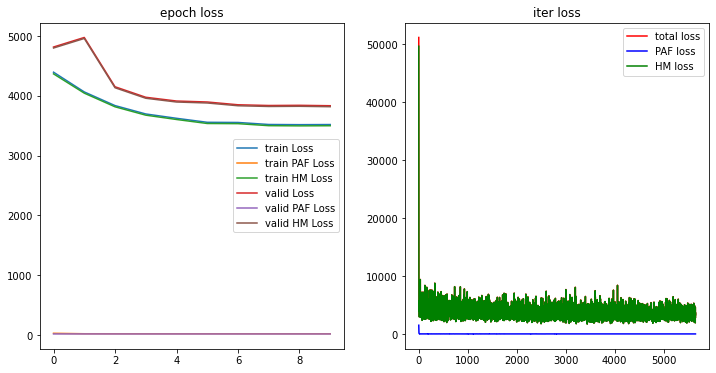

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(np.array(epoch_stats['train'])[:,0],'-', label='train Loss')
plt.plot(np.array(epoch_stats['train'])[:,1],'-', label='train PAF Loss')
plt.plot(np.array(epoch_stats['train'])[:,2],'-', label='train HM Loss')
plt.plot(np.array(epoch_stats['valid'])[:,0],'-', label='valid Loss')
plt.plot(np.array(epoch_stats['valid'])[:,1],'-', label='valid PAF Loss')
plt.plot(np.array(epoch_stats['valid'])[:,2],'-', label='valid HM Loss')

plt.title('epoch loss')
plt.legend();


plt.subplot(122)
plt.plot(np.array(iter_stats['train'])[:,0],'r-', label='total loss')
plt.plot(np.array(iter_stats['train'])[:,1],'b-', label='PAF loss')
plt.plot(np.array(iter_stats['train'])[:,2],'g-', label='HM loss')

plt.title('iter loss');
plt.legend();

plt.show()

In [23]:
json.dump(epoch_stats, open(f'{TRIAL}_{EPOCH}epochs_e.json','w'))
json.dump(iter_stats, open(f'{TRIAL}_{EPOCH}epochs_i.json','w'))